In [ ]:
import numpy as np
import pandas as pd
from build_event_model import *

In [ ]:

# I think no leaks. So this is the most minimal set that
# all seem to have leakers
#pred_columns = [x for x in pred_columns_og
#               if 'last' not in x and 'matchup' not in x
#               and 'this_inning' not in x and 'today' not in x]


from config import pitch_model_train_cutoff
pitch_values = pd.read_parquet('rolling_pitch_value.parquet')
train_pitches = pd.read_parquet('data_with_pitch_values.parquet')
train_pitches = train_pitches[train_pitches.game_date>=pitch_model_train_cutoff]

In [ ]:
# edit time thru order in pitcher vals
cols = ['pitcher', 'player_name','game_date','pitcher_at_bat_number','time_thru_the_order','batter']

cols += [x for x in pitch_values.columns if 'whiff' in x or 'called_strike' in x 
         or 'strikeout' in x or 'homerun' in x or 'woba' in x or 'walk' in x or '_RA9' in x]

cols += [ 'is_CU','is_SL','is_FF_2','is_FF_1','is_SI','is_CH']
pitch_values['time_thru_the_order'] = pitch_values.pitcher_at_bat_number//9 + 1
pitch_values = pitch_values[cols]

train_pitches.strikeout = np.where(train_pitches.end_of_at_bat, train_pitches.strikeout, np.nan)
train_pitches.walk = np.where(train_pitches.end_of_at_bat, train_pitches.walk, np.nan)
train_pitches.homerun = np.where(train_pitches.end_of_at_bat, train_pitches.homerun, np.nan)
train_pitches.single = np.where(train_pitches.end_of_at_bat, train_pitches.single, np.nan)
train_pitches.double = np.where(train_pitches.end_of_at_bat, train_pitches.double, np.nan)
train_pitches.triple = np.where(train_pitches.end_of_at_bat, train_pitches.triple, np.nan)
train_pitches['field_out'] = \
    1 - train_pitches[['walk','homerun','strikeout','single','double','triple']].max(axis=1)



In [ ]:
train_pitches['pitch_type'] = train_pitches['pitch_type'].astype(str)

train_pitches = train_pitches.sort_values(['game_date','at_bat_number','pitch_number'])

train_pitches['at_bat_change'] = \
    (train_pitches.groupby(['pitcher','game_date']).at_bat_number.diff().fillna(0)!=0)

train_pitches['pitcher_at_bat_number'] = train_pitches\
    .groupby(['pitcher','game_date']).at_bat_change.transform('cumsum') + 1

train_pitches['team_at_bat_number'] = train_pitches\
    .groupby(['inning_topbot','game_date','home_team']).at_bat_change.transform('cumsum') + 1

In [ ]:
# add more state info to the game
train_pitches['batting_score'] = np.where(
    train_pitches.inning_topbot=='Top', 
    train_pitches.away_score,
    train_pitches.home_score)

train_pitches['batting_team'] = np.where(
    train_pitches.inning_topbot=='Top', 
    train_pitches.away_team,
    train_pitches.home_team)

train_pitches['lineup_slot'] = 1 + (train_pitches.team_at_bat_number-1)%9
train_pitches['lineup_slot'] = train_pitches.groupby(['batter','game_date'])\
    .lineup_slot.transform('first')

In [ ]:
train_pitches['whiff'] = train_pitches.description.str.contains('swinging_strike')

train_pitches['called_strike'] = train_pitches.description=='called_strike'


In [ ]:
batter_aux = train_pitches\
    [train_pitches.end_of_at_bat][
    ['team_at_bat_number','launch_speed','launch_angle',
     'launch_speed_angle','batter','game_date','hit_distance_sc',
     'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle']]


# need to change these to cummean
batter_aux = batter_aux.sort_values(['game_date','team_at_bat_number'])

batter_aux['estimated_iso'] = \
    batter_aux.estimated_woba_using_speedangle - batter_aux.estimated_ba_using_speedangle

batter_aux['estimated_iso_mean'] = batter_aux.groupby(['batter'])\
    .estimated_iso.transform(lambda x:x.rolling(700, min_periods = 100).mean().shift(1))

batter_aux['estimated_iso_95th'] = batter_aux.groupby(['batter'])\
    .estimated_iso.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.95).shift(1))

batter_aux['estimated_iso_75th'] = batter_aux.groupby(['batter'])\
    .estimated_iso.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.75).shift(1))

batter_aux['estimated_iso_25th'] = batter_aux.groupby(['batter'])\
    .estimated_iso.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.25).shift(1))


batter_aux['launch_angle_mean'] = batter_aux.groupby(['batter'])\
    .launch_angle.transform(lambda x:x.rolling(700, min_periods = 100).mean().shift(1))

batter_aux['launch_speed_mean'] = batter_aux.groupby(['batter'])\
    .launch_speed.transform(lambda x:x.rolling(700, min_periods = 100).mean().shift(1))
batter_aux['launch_speed_max'] = batter_aux.groupby(['batter'])\
    .launch_speed.transform(lambda x:x.rolling(700, min_periods = 100).max().shift(1))

batter_aux['launch_speed_95th'] = batter_aux.groupby(['batter'])\
    .launch_speed.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.95).shift(1))

batter_aux['launch_speed_75th'] = batter_aux.groupby(['batter'])\
    .launch_speed.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.75).shift(1))

batter_aux['launch_speed_25th'] = batter_aux.groupby(['batter'])\
    .launch_speed.transform(lambda x:x.rolling(700, min_periods = 100).quantile(.25).shift(1))


batter_aux['is_barrel'] = batter_aux.launch_speed_angle == 6
batter_aux['is_solid_contact'] = batter_aux.launch_speed_angle == 5
batter_aux['exit_velo_above_95_mph'] = batter_aux.launch_speed > 95
batter_aux['exit_velo_above_100_mph'] = batter_aux.launch_speed > 100

batter_aux['homerun_launch_angle'] = batter_aux.launch_angle.between(25,35)

batter_aux['hit_distance_above_350'] = batter_aux.hit_distance_sc > 350
batter_aux['hit_distance_above_375'] = batter_aux.hit_distance_sc > 375
batter_aux['hit_distance_above_400'] = batter_aux.hit_distance_sc > 400
batter_aux['hit_distance_above_420'] = batter_aux.hit_distance_sc > 420


batter_aux['pct_barrel'] = batter_aux.groupby(['batter'])\
    .is_barrel.transform(lambda x: x.rolling(700,100).mean().shift(1))

batter_aux['pct_solid_contact'] = batter_aux.groupby(['batter'])\
    .is_solid_contact.transform(lambda x: x.rolling(700,100).mean().shift(1))

batter_aux['pct_exit_velo_above_95_mph'] = batter_aux.groupby(['batter'])\
    .exit_velo_above_95_mph.transform(lambda x: x.rolling(700,100).mean().shift(1))

batter_aux['pct_exit_velo_above_100_mph'] = batter_aux.groupby(['batter'])\
    .exit_velo_above_100_mph.transform(lambda x: x.rolling(700,100).mean().shift(1))

batter_aux['pct_homerun_launch_angle'] = batter_aux.groupby(['batter'])\
    .homerun_launch_angle.transform(lambda x: x.rolling(700,100).mean().shift(1))

batter_aux['num_barrel'] = batter_aux.groupby(['batter'])\
    .is_barrel.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['num_solid_contact'] = batter_aux.groupby(['batter'])\
    .is_solid_contact.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['num_exit_velo_above_95_mph'] = batter_aux.groupby(['batter'])\
    .exit_velo_above_95_mph.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['num_exit_velo_above_100_mph'] = batter_aux.groupby(['batter'])\
    .exit_velo_above_100_mph.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['num_homerun_launch_angle'] = batter_aux.groupby(['batter'])\
    .homerun_launch_angle.transform(lambda x: x.rolling(700,100).sum().shift(1))


batter_aux['pct_hit_distance_above_350'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_350.transform(lambda x: x.rolling(700,100).mean().shift(1))
batter_aux['num_hit_distance_above_350'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_350.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['pct_hit_distance_above_375'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_375.transform(lambda x: x.rolling(700,100).mean().shift(1))
batter_aux['num_hit_distance_above_375'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_375.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['pct_hit_distance_above_400'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_400.transform(lambda x: x.rolling(700,100).mean().shift(1))
batter_aux['num_hit_distance_above_400'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_400.transform(lambda x: x.rolling(700,100).sum().shift(1))

batter_aux['pct_hit_distance_above_420'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_420.transform(lambda x: x.rolling(700,100).mean().shift(1))
batter_aux['num_hit_distance_above_420'] = batter_aux.groupby(['batter'])\
    .hit_distance_above_420.transform(lambda x: x.rolling(700,100).sum().shift(1))

In [ ]:
additional_batter_cols =[x for x in batter_aux.columns if 
 'num' in x or 'pct' in x or 'mean' in x or 'max' in x or '5th' in x or '0th' in x]

batter_aux['dummy'] = 1
batter_aux['cumulative_at_bats'] = batter_aux.groupby('batter').dummy.transform('cumsum')

batter_aux['league_average_at_bats'] = 700 - batter_aux['cumulative_at_bats']

l = []
for column in additional_batter_cols:
    if column=='team_at_bat_number':
        continue
    batter_aux[column+'_regressed'] = \
        (batter_aux['league_average_at_bats']*batter_aux[column].mean() + \
        batter_aux['cumulative_at_bats']*batter_aux[column])
    
    batter_aux[column+'_regressed'] /= 700
    l.append(column+'_regressed')
additional_batter_cols += l

In [ ]:


# prep values for rolling window
roll_columns = ['called_strike', 'whiff', 'homerun',
            'walk', 'strikeout', 'estimated_woba_using_speedangle']

sort_columns = ['game_date','batter','at_bat_number']
group_columns = ['batter']
merge_columns = ['batter','game_date']
columns_to_keep = ['walk','field_out','strikeout',
               'single','double','homerun','triple', 'pitcher','pitcher_at_bat_number']
window_size = 700  # Number of pitches thrown
min_period = 200

#train_pitches['is_barrel'] = train_pitches.launch_speed_angle == 6
#train_pitches['is_solid_contact'] = train_pitches.launch_speed_angle == 5

# find rolling performance of batter up to current date
batter_by_game = build_rolling_df(train_pitches[train_pitches.end_of_at_bat], 
                 roll_columns,
                 sort_columns, 
                 group_columns,
                 merge_columns, 
                 columns_to_keep,
                 window_size,
                 min_period,
                 drop_duplicates = False,
                 suffix = "_batter")

In [ ]:

batter_by_game = batter_by_game.sort_values(['game_date','at_bat_number'])
batter_by_game['dummy'] = 1
batter_by_game['cumulative_at_bats'] = batter_by_game.groupby('batter').dummy.transform('cumsum')
batter_by_game.drop(columns='dummy', inplace=True)

In [ ]:
# make a column of regressed performance by throwing in league avg abs till total abs are 700
num_abs_league_average = (700 - batter_by_game.cumulative_at_bats).clip(0)
for col in batter_by_game.columns:
    if '_batter' in col:

        league_avg_performance = num_abs_league_average*batter_by_game[col].median() 
        batter_performance = batter_by_game.cumulative_at_bats*batter_by_game[col]

        total_abs = num_abs_league_average + batter_by_game.cumulative_at_bats
        batter_by_game[col+'_regressed'] = (league_avg_performance + batter_performance) /total_abs

# add label column to batter data for ab but count double and triple the same for now
batter_by_game['double_or_triple'] = batter_by_game[['double','triple']].max(axis=1)

batter_by_game['label'] = np.argmax(batter_by_game[['strikeout','field_out','walk','single',
                                          'double_or_triple','homerun']],axis=1)

In [ ]:

train_batter_cols = [x for x in batter_by_game.columns if '_batter' in x]

at_bat_cols = [x for x in pitch_values.columns if 'last_9' in x or 'next_3' in x]

pitcher_meta = ['pitcher','game_date', 'pitcher_at_bat_number', 'batter']
batter_meta = ['label','pitcher','batter','game_date','pitcher_at_bat_number'] 

summary_stat_cols = [x for x in pitch_values.columns 
              if x not in at_bat_cols
              and x not in train_batter_cols
              and x != 'batter' and x != 'pitcher_at_bat_number']



train_data = pitch_values[at_bat_cols + pitcher_meta ]\
    .merge(batter_by_game[train_batter_cols + batter_meta],
           how ='left', on = pitcher_meta)

train_data = train_data.merge(
    train_pitches[['inning_topbot','inning','on_1b','on_2b','on_3b',
             'game_date','pitcher_at_bat_number','pitcher',
             'team_at_bat_number','batting_team','batting_score',
             'lineup_slot']].drop_duplicates(),
    how = 'left', on = ['game_date','pitcher_at_bat_number','pitcher'])


In [ ]:
pitch_values = pitch_values.sort_values(['game_date','pitcher_at_bat_number'])

# rolling stats at the start of first ab are what you enter the game with
summary_stat_before_first_pitch_df = \
    pitch_values[summary_stat_cols].groupby(['pitcher','game_date']).first().reset_index()

train_data = train_data\
    .merge(summary_stat_before_first_pitch_df, how ='left', on = ['pitcher','game_date'])

meta_cols = ['label', 'player_name','pitcher','batter', 'game_date', 'pitcher_at_bat_number'] 

label = 'label'
ordered_cols = meta_cols+[x for x in train_data.columns if x not in meta_cols]
train_data=train_data[ordered_cols]


In [ ]:
columns_to_drop = [x for x in train_data.columns if 'empirical' in x 
                   and ('last_9' in x or 'next_3' in x)]

train_data[label] = train_data[label].astype('category')

train_data = train_data.drop(columns = columns_to_drop)
pred_columns = [x for x in train_data.columns if x!=label and x not in meta_cols]
pred_columns += ['pitcher_at_bat_number']

In [ ]:
print(train_data.shape, 'before')
# probably have to do this bc i have to pare down to just a single row per AB
train_data = train_data.drop_duplicates(meta_cols)
print(train_data.shape, 'after')

# get rid of na player names
train_data = train_data\
    .dropna(subset=['player_name'])

train_data = add_state_data(train_data)

train_data = train_data.sort_values(['game_date','team_at_bat_number'])
train_data = train_data.reset_index()

# get last ab against pitcher and last ab from batter pitcher matchup
train_data['batter_last_ab'] = train_data.groupby(['pitcher', 'game_date', 'batter']).label.shift(1)    
train_data['last_ab'] = train_data.groupby(['game_date','pitcher']).label.shift(1)


In [ ]:
train_data = train_data.sort_values(['game_date', 'team_at_bat_number'])
train_data['at_bat_woba'] = 1.2*(
    .55*(train_data.label==2) + .7*(train_data.label==3) +\
    1.0*(train_data.label==4) + 1.65*(train_data.label==5))


# these should technically be changed to not include at bat
train_data['woba_batter'] = train_data.groupby(['batter'])\
    .at_bat_woba.transform(lambda x:x.rolling(window=700, min_periods=300).mean())
train_data['woba_batter'] = train_data.groupby(['batter']).woba_batter.shift(1)


train_data['next_batter_woba'] = train_data\
    .groupby(['game_date','inning_topbot', 'batting_team']).woba_batter.shift(-1)

train_data['woba_pitcher'] = train_data.groupby(['pitcher'])\
    .at_bat_woba.transform(lambda x:x.rolling(window=700, min_periods=300).mean())
train_data['woba_pitcher'] = train_data.groupby(['pitcher']).woba_pitcher.shift(1)

train_data = train_data.dropna(subset='label')


In [ ]:
if False:

    matchup_lookup = setup_batter_pitcher_matchups(train_data, pitches)
    matchup_lookup.to_parquet('matchup_lookup.parquet')
else:
    matchup_lookup = pd.read_parquet('matchup_lookup.parquet')

matchup_lookup.pitcher = matchup_lookup.pitcher.astype(int)
matchup_lookup.batter = matchup_lookup.batter.astype(int)
train_data.pitcher = train_data.pitcher.astype(int)
train_data.batter = train_data.batter.astype(int)

matchup_lookup['game_date'] = pd.to_datetime([str(y)+'-'+str(m) 
                                for y, m in zip(matchup_lookup.year, matchup_lookup.month)])
train_data = pd.merge_asof(
    train_data,
    matchup_lookup.drop(columns = ['month','year']).sort_values('game_date'), 
    by = ['batter','pitcher'],
    on='game_date',
    direction='backward')

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

one_hot_encoder.fit(train_data.head(100000)[['last_ab', 'batter_last_ab']].dropna())
#imputed_train_data = impute_nas(train_data)

In [ ]:
train_data = train_data.drop(columns = [x for x in additional_batter_cols 
                                        if x !='team_at_bat_number' and x in train_data.columns])

In [ ]:
train_data = train_data.drop(columns = [x for x in train_data.columns
                                        if 'matchup' in x and 'today' in x])

In [ ]:
batter_aux = batter_aux.groupby(['game_date','batter']).first().reset_index()

In [ ]:
train_data = train_data.merge(
    batter_aux[additional_batter_cols + ['game_date', 'batter']]\
        .drop(columns = 'team_at_bat_number'),
    how = 'left', on = ['game_date', 'batter'])

In [ ]:
train_data = train_data[[x for x in train_data.columns if '_x'!=x[-2:] and '_y'!=x[-2:]]]

In [ ]:
train_data['homerun_intensity'] = train_data['homerun_pitcher'].fillna(0) + \
    train_data.homerun_batter.fillna(0)
train_data['walk_intensity'] = train_data['walk_pitcher'].fillna(0) + \
    train_data.walk_batter.fillna(0)
train_data['strikeout_intensity'] = train_data['strikeout_pitcher'].fillna(0) + \
    train_data.strikeout_batter.fillna(0)

for column in additional_batter_cols:
    train_data[column] =  pd.to_numeric(train_data[column], errors='coerce')

imputed_train_data  = train_data

In [ ]:
imputed_train_data = imputed_train_data.drop(columns =  
                                             [x for x in imputed_train_data.columns if 'last_9' in x
                                             and 'pred' in x]+
                                             ['homerun','double', 'single','walk',
                                              'strikeout','linear_weight', 'at_bat_woba'])

In [ ]:
imputed_train_data['time_thru_the_order'] = imputed_train_data.pitcher_at_bat_number//9 + 1

In [ ]:
imputed_train_data[
    imputed_train_data.player_name == 'Strider, Spencer']\
    .sort_values('game_date',ascending=False)

In [ ]:
d = {x:'mean' for x in ['strikeout','field_out', 'walk','single','double','homerun']}
d['at_bat_number']=len
bdf = batter_by_game.groupby('batter').agg(d)
bdf = bdf[bdf.at_bat_number > 200]
np.percentile(bdf, 5, axis = 0)

In [494]:
import torch.nn as nn
import torch

from spacecutter.models import OrdinalLogisticModel
num_features = xtest_enc.shape[1]

import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.5):
        super(MyModel, self).__init__()
        
        # Create a list to hold the layers
        layers = []
        
        # Add the first layer
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            prev_size = hidden_size
        
        # Add the final layer (output layer)
        layers.append(nn.Linear(prev_size, 1))
        
        # Combine all layers into a sequential module
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass through the model

        return self.network(x)



predictor = MyModel(num_features, hidden_sizes=[128, 128, 128], dropout_prob=.5)

num_classes = len(np.unique(train_label))
model = OrdinalLogisticModel(predictor, num_classes)

X_tensor = torch.as_tensor(xtrain_enc.values.astype(np.float32))
X_tensor = torch.as_tensor(xtrain_enc.values.astype(np.float32))

predictor_output = predictor(X_tensor).detach()
model_output = model(X_tensor).detach()

In [495]:
from spacecutter.losses import CumulativeLinkLoss
from spacecutter.callbacks import AscensionCallback
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from skorch.callbacks import Callback, ProgressBar
from skorch.net import NeuralNet

skorch_model = NeuralNet(
    module=OrdinalLogisticModel,
    module__predictor=predictor,
    module__num_classes=num_classes,
    criterion=CumulativeLinkLoss,
    max_epochs=100,
    optimizer=torch.optim.Adam,
    lr = .1,
    optimizer__weight_decay=0.0,
    device='cpu',
    callbacks=[
        ('ascension', AscensionCallback()),
    ],
    train_split=None,
    verbose=0,
)

def to_float(x):
    return x.astype(np.float32)

pipeline = Pipeline([
    ('caster', FunctionTransformer(to_float)),
    ('net', skorch_model)
])

param_grid = {
    'net__max_epochs': np.array([10]).astype(int),
    'net__lr': np.logspace(-4, -1, 2),
}

def mae_scorer(y_true, y_pred):

    return mean_absolute_error(y_true, y_pred.argmax(axis = 1))

scoring = make_scorer(mae_scorer,
                      greater_is_better=False,
                      needs_proba=False)

sc_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)

y_train = train_label.astype(int).values.reshape(-1, 1)
sc_grid_search.fit(xtrain_enc.fillna(-1).values, y_train)

/usr/local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: 

In [497]:
import pickle
with open('data_for_ordinal.pkl','wb') as f:
    pickle.dump({'x':xtrain_enc, 'y':train_label},f)

In [526]:
def weighted_cross_entropy_with_distances_proba( y_pred_proba, y_true, class_distances):
    """
    Compute the weighted cross-entropy loss with distances between classes using predicted probabilities.

    Args:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    class_distances (np.ndarray): Distance matrix between classes.

    Returns:
    float: Weighted cross-entropy loss.
    """
    # Convert y_true to tensor
    y_true = torch.tensor(y_true, dtype=torch.int)
 
    # Convert y_pred_proba to tensor
    y_pred_proba = torch.tensor(y_pred_proba, dtype=torch.float32)

    # Calculate the cross-entropy loss for each class pair
    cross_entropy_loss = -torch.log(y_pred_proba[range(len(y_true)), y_true] + 1e-6)
    
    # Calculate the weights based on the distances and predicted probabilities
    weights = torch.zeros_like(cross_entropy_loss)
    for i in range(len(y_true)):
        for j in range(y_pred_proba.shape[1]):
            weights[i] += class_distances[y_true[i], j] * y_pred_proba[i, j]

    # Compute the weighted loss
    weighted_loss = cross_entropy_loss * weights
    
    # Return the mean weighted loss
    return weighted_loss.mean().item()

num_classes=6
x = [[.3,.5,.2, 0,0,0], [0,0,0,0,1,0], [1,0,0,0,0,0]]
w = [-.3, -.2, .55, .7, 1, 1.65]
y = [5,5, 5]
distance_matrix = np.zeros((len(w), len(w)))

for i in range(num_classes):
    for j in range(num_classes):
        distance_matrix[i, j] = np.abs(w[i] - w[j]) + .1
weighted_cross_entropy_with_distances_proba(x, y, distance_matrix)

tensor([1.8300, 0.7500, 2.0500])


21.32193946838379

In [532]:
import torch
torch.load('optimizer.pt')

{'state': {0: {'step': tensor(132600.),
   'exp_avg': tensor([[-3.1275e-03, -8.8699e-05, -2.5518e-04,  ...,  5.6655e-05,
            -4.7746e-06, -9.9344e-07],
           [-8.2879e-05, -4.4173e-05, -2.6239e-05,  ...,  5.9226e-06,
             1.7371e-06,  6.1857e-06],
           [-1.6083e-03, -4.7860e-04, -5.5407e-04,  ..., -1.8762e-05,
             3.3984e-06,  1.0774e-06],
           ...,
           [ 2.3339e-06,  1.0954e-04,  1.7025e-04,  ..., -8.8312e-07,
             1.9845e-06,  7.0665e-07],
           [-1.4140e-03, -4.5357e-04, -4.3816e-04,  ..., -1.0754e-05,
             1.4992e-06,  3.3558e-06],
           [ 1.2625e-06, -3.6597e-05, -1.0312e-04,  ...,  3.3887e-06,
             1.3455e-06,  4.4159e-06]]),
   'exp_avg_sq': tensor([[5.3415e-05, 7.9479e-06, 7.8967e-06,  ..., 2.0838e-08, 6.4036e-09,
            4.9571e-09],
           [1.5843e-05, 2.3684e-06, 2.3811e-06,  ..., 5.0605e-09, 1.8049e-09,
            1.2799e-09],
           [3.4867e-05, 6.8797e-06, 6.8697e-06,  ..., 1.2

In [ ]:
dis

In [474]:
y_pred = sc_grid_search.predict_proba(xtest_enc.fillna(-1).values)#.argmax(axis=1)

In [483]:
d = pd.concat([
    xtest.reset_index(), pd.DataFrame(y_pred, columns = ['pred_'+x for x in 
                                  ['strikeout','fieldout','walk','single','double','homerun']])],
 axis = 1)

In [500]:
d[['homerun_batter','homerun_pitcher','woba_batter','woba_pitcher', 'batter','pitcher']+\
    [x for x in d.columns if 'pred' in x and 'value' not in x]]\
    .dropna(subset='woba_batter')\
    .groupby('batter').mean()\
    .sort_values('woba_batter').tail(50)

,homerun_batter,homerun_pitcher,woba_batter,woba_pitcher,pitcher,pred_strikeout,pred_fieldout,pred_walk,pred_single,pred_double,pred_homerun
batter,,,,,,,,,,,
683002,0.042654,0.030364,0.325961,0.284760,630632.206019,0.240471,0.477727,0.078094,0.131911,0.043838,0.027959
621439,0.067111,0.031290,0.326325,0.290248,626152.402985,0.261002,0.478617,0.073715,0.121794,0.039728,0.025144
571970,0.058998,0.032638,0.326567,0.286981,627435.446575,0.245156,0.478425,0.077066,0.129378,0.042764,0.027212
608841,0.029348,0.029753,0.326996,0.284669,625721.720379,0.222739,0.474985,0.082028,0.141557,0.047906,0.030785
668227,0.037064,0.029839,0.327015,0.286131,631001.320574,0.253719,0.478664,0.075235,0.125213,0.041094,0.026074
663457,0.035808,0.031066,0.327510,0.285722,627252.667712,0.232826,0.476864,0.079783,0.135930,0.045496,0.029101
677594,0.048272,0.031367,0.327812,0.285481,630657.950324,0.242551,0.478320,0.077617,0.130656,0.043286,0.027570
666181,0.030470,0.032001,0.328453,0.286586,633513.011628,0.273496,0.476859,0.071230,0.116697,0.037829,0.023889
668939,0.029949,0.030369,0.328794,0.284379,629979.637813,0.230257,0.476328,0.080351,0.137386,0.046130,0.029547


In [377]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.mord
categorical_columns=['last_ab','batter_last_ab']
meta_columns = ['player_name','pitcher','batter', 
                                                   'game_date','inning_topbot','batting_team']
# Example Data Preparation
xtrain = imputed_train_data[imputed_train_data.game_date<='2023-06-01']
xtest = imputed_train_data[imputed_train_data.game_date>'2023-06-01']
train_label = xtrain.label
test_label = xtest.label

pred_columns = [x for x in imputed_train_data.columns 
                if x!='label' and x not in meta_columns and x!='index']


xtrain_enc = one_hot_encode_data(one_hot_encoder, xtrain[pred_columns],
                             categorical_columns)
xtest_enc = one_hot_encode_data(one_hot_encoder, xtest[pred_columns], 
                             categorical_columns)
# Thresholds
thresholds = [1, 2, 3, 4, 5]

# Dictionary to hold calibrated models
calibrated_models = {}

# Train and calibrate binary classifiers for each threshold
for threshold in thresholds:
    y_train_binary = (train_label.astype(int) >= threshold).astype(int)
    
    # Train the XGBoost classifier
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(xtrain_enc, y_train_binary)
    
    # Calibrate the classifier
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    calibrated_model.fit(x_enc, y_train_binary)
    
    # Save the calibrated model
    calibrated_models[threshold] = calibrated_model

# Function to predict calibrated probabilities
def predict_calibrated_probabilities(X):
    probas = np.zeros((X.shape[0], len(thresholds) + 1))
    prev_proba = np.ones(X.shape[0])
    
    for i, threshold in enumerate(thresholds):
        model = calibrated_models[threshold]
        proba = model.predict_proba(X)[:, 1]  # Calibrated probability of being >= threshold
        
        probas[:, i] = prev_proba * (1 - proba)
        prev_proba = prev_proba * proba
    
    probas[:, -1] = prev_proba  # The probability of the highest class
    
    return probas


# Predict calibrated probabilities on the test set
probas = predict_calibrated_probabilities(xtest_enc)

# Sample from the predicted probabilities
predicted_classes = [np.random.choice(len(thresholds) + 1, p=p) for p in probas]

# Evaluate the predictions
predicted_classes = np.array(predicted_classes)


In [380]:
probas.round(2)

array([[0.21, 0.69, 0.08, 0.02, 0.  , 0.  ],
       [0.59, 0.27, 0.14, 0.01, 0.  , 0.  ],
       [0.24, 0.63, 0.12, 0.01, 0.  , 0.  ],
       ...,
       [0.32, 0.68, 0.  , 0.  , 0.  , 0.  ],
       [0.38, 0.43, 0.19, 0.  , 0.  , 0.  ],
       [0.18, 0.78, 0.04, 0.  , 0.  , 0.  ]])

In [372]:
import numpy as np

def cheng_labels(y_label, n_classes):
    """
    Encode ordinal labels using cumulative binary vectors.
    
    Args:
        y_label: A 1D numpy array of shape (num_samples,) containing the ordinal labels.
        n_classes: The number of ordinal classes.
    
    Returns:
        encoded_labels: A 2D numpy array of shape (num_samples, n_classes) containing the encoded labels.
    """
    # Initialize an array for the encoded labels
    encoded_labels = np.zeros((len(y_label), n_classes))
    
    # Fill the encoded labels
    for i in range(n_classes):
        encoded_labels[:, i] = (y_label > i).astype(int)
    
    return encoded_labels


def create_ordinal_ce_eval_metric(y_test, n_classes):
    def eval_metric(y_pred, dtest):
        """
        Custom evaluation metric for XGBoost.
        
        :param y_pred: Predictions from the model.
        :param dtest: DMatrix containing test data.
        :return: Tuple (metric_name, value, higher_better).
        """

        preds = y_pred.reshape(-1, n_classes)
        labels = cheng_labels(y_test, n_classes) #dtest.get_label()
        
        # Transform predictions to probabilities using sigmoid
        # Compute the softmax of the predictions
        preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))
        preds /= np.sum(preds, axis=1, keepdims=True)

        probas = 1 - np.cumsum(preds, axis = 1) 

        # Calculate the loss (binary cross-entropy for each class threshold)
        loss = -np.mean(labels[:,:-1] * np.log(probas[:,:-1] + 1e-15) + \
                            (1 - labels[:,:-1]) * np.log(1 - probas[:,:-1] + 1e-15))
        return 'ordinal_ce_loss', loss

    return eval_metric


def create_ordinal_ce(y_train, n_classes):
    """
    Creates a custom loss function with closure to access y_train.
    
    Args:
        n_classes: The number of ordinal classes.
    
    Returns:
        A custom loss function that can access y_train.
    """
    def ordinal_ce(y_pred, dtrain):
        """
        Custom objective function with label smoothing for XGBoost.
        
        Args:
            y_pred: Predicted probabilities from the model (numpy array).
            dtrain: XGBoost DMatrix containing training features and labels.
        
        Returns:
            grad: Gradient of the loss function.
            hess: Hessian of the loss function.
        """

        preds = y_pred.reshape(-1, n_classes)
        #labels = y_train#dtrain.get_label()
        #labels = cheng_labels(y_train, n_classes)
        labels = np.cumsum(labels, axis = 1)[:,:-1]
        probas = np.cumsum(preds)[:,:-1]
        # Transform predictions to probabilities using sigmoid

        loss = -np.mean(labels * np.log(probas + 1e-15) + (1 - labels) * np.log(1 - probas + 1e-15))
        
        # Compute the softmax of the predictions
        preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))
        preds /= np.sum(preds, axis=1, keepdims=True)

        print('preds in proba form', preds[0:2])
        probas = 1 - np.cumsum(preds, axis = 1) 

        print('preds in ordinal form', probas[0:2])
        
        # Calculate the loss (binary cross-entropy for each class threshold)
        loss = -np.mean(labels[:,:-1] * np.log(probas[:,:-1] + 1e-15) + \
                            (1 - labels[:,:-1]) * np.log(1 - probas[:,:-1] + 1e-15))
        
        # Calculate the gradient
        grad = probas - labels
        
        # Calculate the hessian
        hess = probas * (1 - probas)
        
        return grad.flatten(), hess.flatten()

    return ordinal_ce




def setup_ordinal_model(imputed_train_data, 
                        one_hot_encoder,
                        num_classes=6,
                        categorical_columns=['last_ab','batter_last_ab'],
                        meta_columns = ['player_name','pitcher','batter', 
                                        'game_date','inning_topbot','batting_team']):

    xtrain = imputed_train_data[imputed_train_data.game_date<='2023-06-01']
    xtest = imputed_train_data[imputed_train_data.game_date>'2023-06-01']
    train_label = xtrain.label
    test_label = xtest.label
    
    pred_columns = [x for x in imputed_train_data.columns 
                    if x!='label' and x not in meta_columns and x!='index']

  
    xtrain_enc = one_hot_encode_data(one_hot_encoder, xtrain[pred_columns],
                                 categorical_columns)
    xtest_enc = one_hot_encode_data(one_hot_encoder, xtest[pred_columns], 
                                 categorical_columns)
        
    y_train_cheng = cheng_labels( train_label.astype(int), num_classes)
    
    y_test_cheng =  cheng_labels( test_label.astype(int), num_classes)
    
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.array([0,1,2,3,4,5]),
                                         y=train_label)
    sample_weights = np.array([class_weights[class_] for class_ in train_label.astype(int)])
    
    dtrain = xgb.DMatrix(xtrain_enc, label=train_label.astype(int), weight=sample_weights)
    dtest = xgb.DMatrix(xtest_enc, label =test_label.astype(int))
    
    custom_loss_fn = create_ordinal_ce(train_label.astype(int), num_classes)
    
    custom_eval_fn = create_ordinal_ce_eval_metric(test_label.astype(int), num_classes)
    
    # Set parameters
    model_params = {
      'objective': 'multi:softprob',  # Use custom objective function
      'max_depth': 8,
      'eta': 0.01,
      'num_class': num_classes,
    }

    bst = xgb.train(model_params, dtrain, num_boost_round=50, 
                     evals=[(dtest, 'test')],
                    early_stopping_rounds=5,
                    obj=custom_loss_fn,
                    custom_metric=custom_eval_fn)
    return bst, xtrain, xtrain_enc,  dtrain, xtest, xtest_enc,  dtest



In [373]:
from sklearn.utils.class_weight import compute_class_weight

def setup_adaptive_smoothing_model(imputed_train_data, 
                                   one_hot_encoder,
                                   num_classes=6,
                                   alpha = 1,
                                   smoothing_prior = None,
                                   categorical_columns=['last_ab','batter_last_ab'],
                                   meta_columns = ['player_name','pitcher','batter', 
                                                   'game_date','inning_topbot','batting_team']):
    

    if smoothing_prior is None:
        smoothing_prior = np.array([.02]*num_classes)
        
    xtrain = imputed_train_data[imputed_train_data.game_date<='2023-06-01']
    xtest = imputed_train_data[imputed_train_data.game_date>'2023-06-01']
    train_label = xtrain.label
    test_label = xtest.label
    
    pred_columns = [x for x in imputed_train_data.columns 
                    if x!='label' and x not in meta_columns and x!='index']
    #pred_columns = [x for x in pred_columns if x not in categorical_columns]
    #categorical_columns = []
    
  
    xtrain_enc = one_hot_encode_data(one_hot_encoder, xtrain[pred_columns],
                                 categorical_columns)
    xtest_enc = one_hot_encode_data(one_hot_encoder, xtest[pred_columns], 
                                 categorical_columns)
        
    y_train_smoothed = empirical_label_smoothing( train_label.astype(int),
                                                 smoothing_prior, alpha, num_classes)
    
    y_test_smoothed = empirical_label_smoothing( test_label.astype(int),
                                                 smoothing_prior, alpha, num_classes)

    #class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4,5]),
                                         #y=train_label)
    #sample_weights = np.array([class_weights[class_] for class_ in train_label.astype(int)])
    
    dtrain = xgb.DMatrix(xtrain_enc, label=train_label)#, weight=sample_weights)
    dtest = xgb.DMatrix(xtest_enc, label = test_label)
    
    custom_loss_fn = create_custom_loss(train_label,prior=smoothing_prior,
                                        alpha=alpha, n_classes = num_classes )
    
    custom_eval_fn = create_custom_eval_metric(y_test_smoothed,prior=smoothing_prior, 
                                               alpha=alpha,n_classes = num_classes)
    
    # Set parameters
    model_params = {
      'objective': 'multi:softprob',  # Use custom objective function
      'max_depth': 8,
      'eta': 0.01,
        'num_class': num_classes,
        'eval':'mlogloss'
    }

    custom_loss_fn = 'multi:softprob'
    custom_eval_fn = 'mlogloss'
    
    #model = XGBClassifier(**model_params)
    bst = xgb.train(model_params, dtrain, num_boost_round=500, 
                     evals=[(dtest, 'test')],
                    early_stopping_rounds=5)
                    #obj=custom_loss_fn)
                    #custom_metric=custom_eval_fn)
    return bst, xtrain, xtrain_enc,  dtrain, xtest, xtest_enc,  dtest



#prior = None
'''
prior = np.array([0.0]*6)
model, xtrain, xtrain_enc, dtrain, xtest, xtest_enc, dtest = \
    setup_adaptive_smoothing_model(imputed_train_data, 
                                one_hot_encoder,
                                num_classes=6,
                                alpha = 1,
                                smoothing_prior = prior,
                                categorical_columns=['last_ab','batter_last_ab'],
                                meta_columns = ['player_name','pitcher','batter', 
                                                   'game_date','inning_topbot','batting_team'])
'''

model, xtrain, xtrain_enc, dtrain, xtest, xtest_enc, dtest = \
    setup_ordinal_model(imputed_train_data, 
                        one_hot_encoder,
                        num_classes=6,
                        categorical_columns=['last_ab','batter_last_ab'],
                        meta_columns = ['player_name','pitcher','batter', 
                                           'game_date','inning_topbot','batting_team'])

preds in proba form [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]
preds in ordinal form [[0.8333333  0.6666666  0.5        0.3333333  0.16666663 0.        ]
 [0.8333333  0.6666666  0.5        0.3333333  0.16666663 0.        ]]
[0]	test-mlogloss:1.79496	test-ordinal_ce_loss:0.56599
preds in proba form [[0.16721453 0.1655429  0.1662526  0.16627589 0.16654001 0.16817407]
 [0.16721453 0.1655429  0.1662526  0.16627589 0.16654001 0.16817407]]
preds in ordinal form [[0.8327855  0.6672426  0.50099    0.33471406 0.16817403 0.        ]
 [0.8327855  0.6672426  0.50099    0.33471406 0.16817403 0.        ]]
[1]	test-mlogloss:1.79821	test-ordinal_ce_loss:0.56695
preds in proba form [[0.1677715  0.16442221 0.1658298  0.1658782  0.16640522 0.1696931 ]
 [0.1677715  0.16442221 0.1658298  0.1658782  0.16640522 0.1696931 ]]
preds in ordinal form [[0.8322285  0.66780627 0.5019765  0.3360983  0.16969311 0.        ]


In [ ]:
cheng_labels(train_data.label.astype(int), 6).sum(axis = 0)

In [342]:
probas = model.predict(dtest, output_margin=True)

In [357]:
probas = probas/probas.sum(axis = 1)[:,np.newaxis]

In [358]:


true_probas = np.zeros_like(probas)
true_probas[:,0] = 1 - probas[:,0]
                
for i in range(1,5):
    true_probas[:,i] = 1 - true_probas[:,:i].sum(axis=1) - probas[:,i+1]

true_probas[:,-1] = 1 - true_probas.sum(axis=1)

In [362]:
probas.mean(axis = 0)

array([ 0.5172221 ,  0.22666568,  0.17344564,  0.06524611,  0.02333615,
       -0.00591288], dtype=float32)

In [365]:
true_probas.mean(axis = 0)

array([ 0.48277894,  0.34377614,  0.10819826,  0.04190969,  0.02924913,
       -0.00591288], dtype=float32)

In [364]:
np.cumsum(probas, axis = 1)- np.cumsum(probas[1:], axis = 1)

ValueError: operands could not be broadcast together with shapes (119832,6) (119831,6) 

In [235]:
(np.cumsum(probas[1:-1], axis = 1) - np.cumsum(probas[:-2], axis = 1)).round(2)

array([[-0.11, -0.03, -0.01, -0.  , -0.  ,  0.  ],
       [ 0.01, -0.03, -0.  , -0.  ,  0.  ,  0.  ],
       [-0.02, -0.01, -0.02,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.09,  0.04,  0.02,  0.  ,  0.  ,  0.  ],
       [ 0.04,  0.01,  0.  ,  0.  , -0.  ,  0.  ],
       [-0.16, -0.03, -0.02, -0.  , -0.  ,  0.  ]], dtype=float32)

In [ ]:
13% of the time we get a K
87% of the time we get a field out or better
6% of the time we get a walk or better
5% of the time we get a single or better
1% of the time we get a double or better

81 - 13% of the time we get a field out
93 -

In [ ]:
def proba_to_pred(proba):
    [.1, .3,.1,.5]
    [.9, .6, .5, 0]
    np.cumsum(proba)

In [246]:
1 - np.cumsum([0,0,1])

array([1, 1, 0])

In [237]:
probas[0].round(2)

array([0.87, 0.06, 0.05, 0.01, 0.  , 0.  ], dtype=float32)

In [195]:
np.cumprod(probas,axis =1 ).max(axis=0)

array([9.8401421e-01, 2.1141084e-01, 2.9269518e-02, 2.3068045e-03,
       1.2905197e-04, 2.4540908e-08], dtype=float32)

In [ ]:
test = pd.concat([xtest.reset_index(), pd.DataFrame(
    probas, columns = ['pred_strikeout','pred_fieldout','pred_walk',
                       'pred_single','pred_double','pred_homerun'])], axis = 1)

In [ ]:
pd.options.display.max_columns = 300
print((test.sort_values('pred_homerun').tail(50).label==5).mean())

(test.sort_values('homerun_intensity').tail(100).label==5).mean()

In [ ]:
train_data.to_parquet('train_data_for_fit.parquet')

In [ ]:
np.percentile(probas[:,:2].sum(axis=1), range(0,110,10))

In [ ]:
l=['homerun_batter','homerun_pitcher','label','pred_homerun']
l+=[x for x in test.columns if x not in l]

In [ ]:
test[l]\
    .sort_values('pred_homerun').tail(50)

<Figure size 1000x800 with 0 Axes>

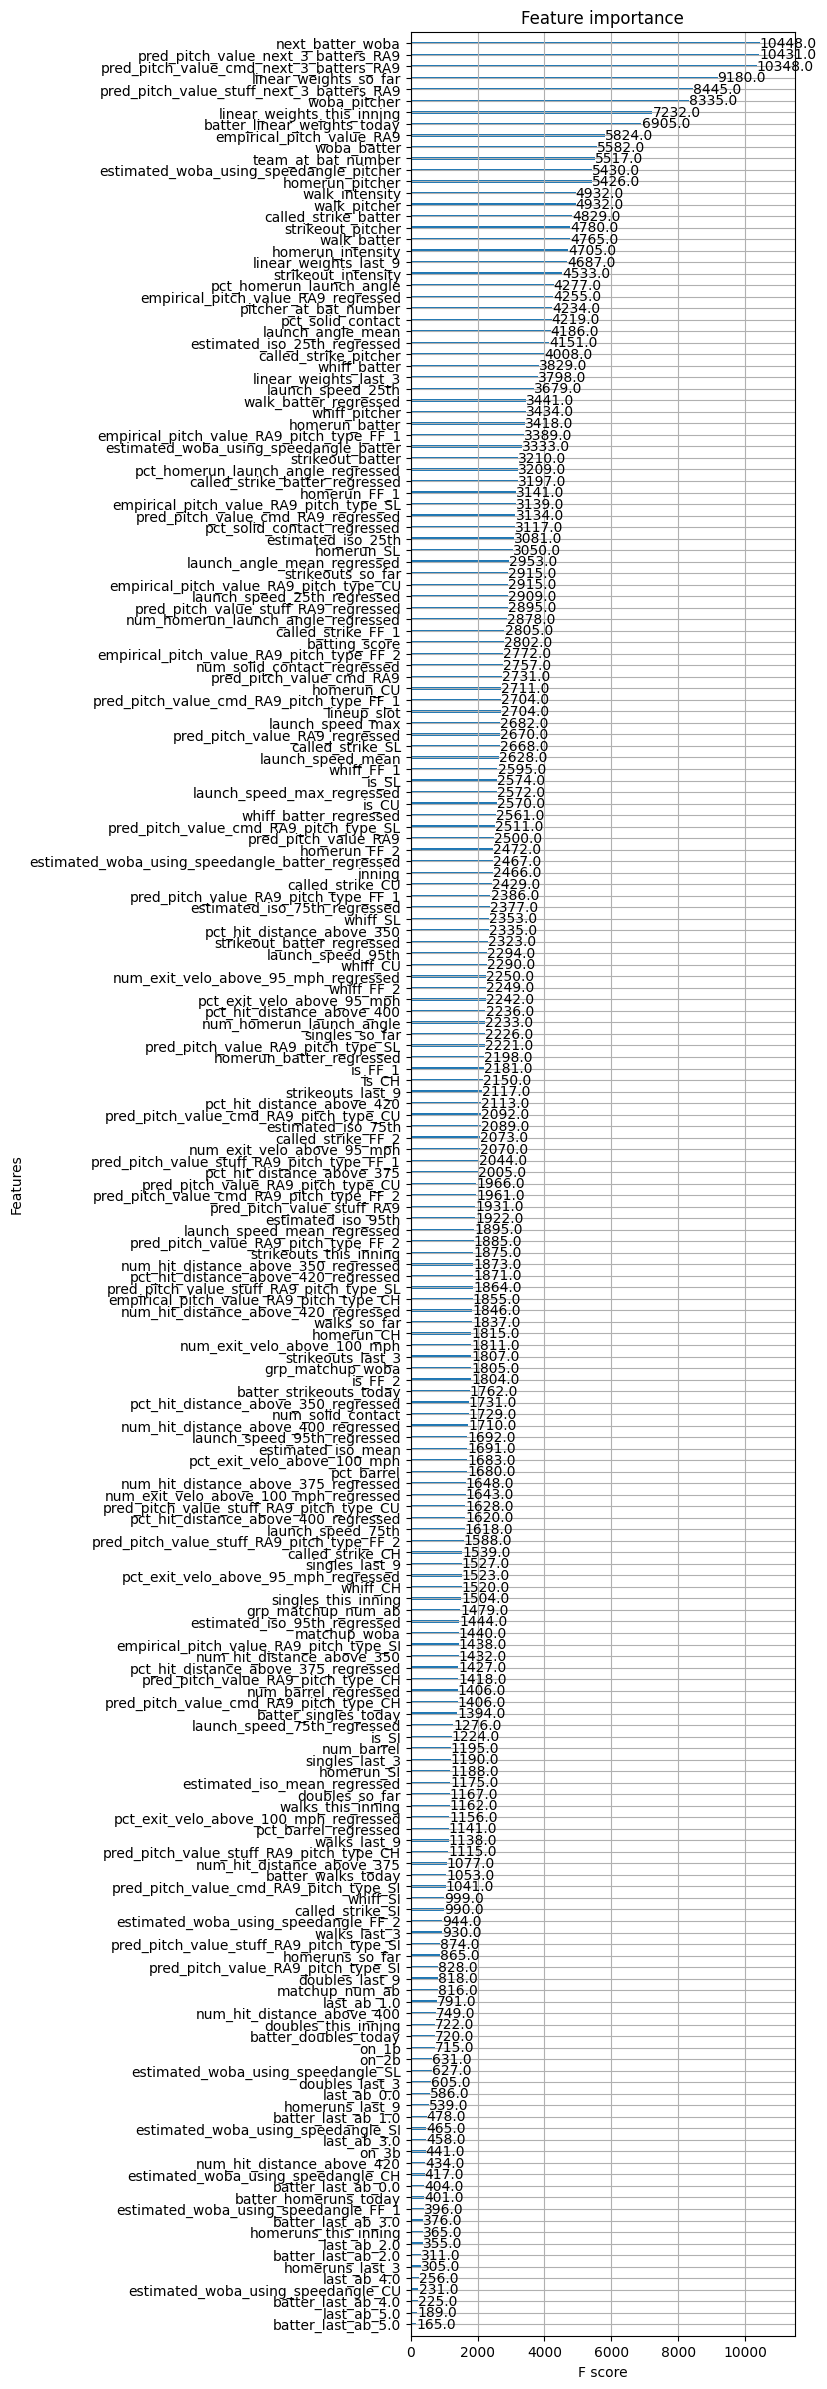

In [170]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Create a larger figure
plt.figure(figsize=(10, 8))

# Plot feature importances
xgb.plot_importance(model)

# Adjust margins
plt.subplots_adjust(left=0.2, right=.8, top=4.9, bottom=0.1)

# Show plot
plt.show()


# BREAK

In [ ]:

data_for_pitcher_pull = train_pitches[train_pitches.end_of_at_bat].copy(deep=True)

data_for_pitcher_pull = data_for_pitcher_pull.sort_values(
    ['game_date','pitcher','pitcher_at_bat_number'])


data_for_pitcher_pull['is_start'] = data_for_pitcher_pull \
    .groupby(['pitcher','game_date']).inning.transform('min') == 1

data_for_pitcher_pull['month'] = data_for_pitcher_pull.game_date.dt.month
data_for_pitcher_pull['day'] = data_for_pitcher_pull.game_date.dt.day

data_for_pitcher_pull = data_for_pitcher_pull[np.logical_or(
    data_for_pitcher_pull.month>4, data_for_pitcher_pull.day > 10)]

data_for_pitcher_pull = data_for_pitcher_pull[data_for_pitcher_pull.is_start]

data_for_pitcher_pull['runs_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).runs.transform('cumsum')

data_for_pitcher_pull['runs_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher', 'game_date']).runs.transform('cumsum')

data_for_pitcher_pull['outs_recorded_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher', 'game_date']).out.transform('cumsum').clip(0,27)

data_for_pitcher_pull['outs_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).out.transform('cumsum').clip(0,3)

data_for_pitcher_pull['homeruns_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).homerun.transform('cumsum')

data_for_pitcher_pull['homeruns_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher','game_date']).homerun.transform('cumsum')

data_for_pitcher_pull['hits_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).hit.transform('cumsum')

data_for_pitcher_pull['hits_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher','game_date']).hit.transform('cumsum')

data_for_pitcher_pull['walks_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher','game_date']).walk.transform('cumsum')

data_for_pitcher_pull['walks_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).walk.transform('cumsum')

data_for_pitcher_pull['strikeouts_this_game'] = data_for_pitcher_pull \
    .groupby(['pitcher','game_date']).strikeout.transform('cumsum')

data_for_pitcher_pull['strikeouts_this_inning'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning', 'game_date']).strikeout.transform('cumsum')






data_for_pitcher_pull = data_for_pitcher_pull[['inning','pitcher','player_name','runs',
                        'homerun','walk','strikeout','hit',
                       'out', 'pitcher_at_bat_number','game_date','batter'] + \
    [x for x in data_for_pitcher_pull if 'this_game' in x or 'this_inning' in x]]


data_for_pitcher_pull['total_outs_recorded_by_end_of_game'] = data_for_pitcher_pull\
    .groupby(['pitcher','game_date']).outs_recorded_this_game.transform('max')

df_for_perc = data_for_pitcher_pull.drop_duplicates(['game_date','pitcher']).copy(deep=True)

for perc in [.05, .25,.5, .75, .95]:
    
    cumulative_percentile_by_group = df_for_perc\
        .groupby('pitcher')['total_outs_recorded_by_end_of_game'].expanding().quantile(perc)
    
    # Add the result as a new column
    df_for_perc[f'total_outs_recorded_{int(perc*100)}_perc'] = \
        cumulative_percentile_by_group.reset_index(level=0, drop=True)
    
perc_columns = [x for x in df_for_perc.columns if '_perc' in x]
data_for_pitcher_pull = data_for_pitcher_pull\
    .merge(df_for_perc[perc_columns + ['game_date','pitcher']],
                            how = 'left', on=['game_date','pitcher'])

data_for_pitcher_pull['max_outs_recorded_by_end_of_game'] = data_for_pitcher_pull\
    .groupby(['pitcher']).total_outs_recorded_by_end_of_game.transform(np.maximum.accumulate)

data_for_pitcher_pull['min_outs_recorded_by_end_of_game'] = data_for_pitcher_pull\
    .groupby(['pitcher']).total_outs_recorded_by_end_of_game.transform(np.minimum.accumulate)


cumulative_mean_func = lambda x: x.cumsum() / range(1, len(x) + 1)
data_for_pitcher_pull['mean_recorded_by_end_of_game'] = data_for_pitcher_pull \
    .groupby(['pitcher','inning']).total_outs_recorded_by_end_of_game.transform(cumulative_mean_func)


data_for_pitcher_pull.drop(columns='total_outs_recorded_by_end_of_game', inplace=True)
data_for_pitcher_pull['pulled'] = data_for_pitcher_pull.groupby([
    'pitcher','game_date']).pitcher_at_bat_number.transform(lambda x: x == max(x))

In [ ]:
from engineer_features import train_xgboost
meta = ['pitcher','player_name','game_date','batter']
target = 'pulled'

pull_pitcher_cols = [x for x in data_for_pitcher_pull.columns if x not in meta+[target]]
X_pulled_train = data_for_pitcher_pull[data_for_pitcher_pull.game_date<='2023-06-01']
X_pulled_test = data_for_pitcher_pull[data_for_pitcher_pull.game_date>='2023-06-01']


xg_model_pull = train_xgboost(data_for_pitcher_pull,
              target_column='pulled',
              pred_columns=pull_pitcher_cols,
              categorical_columns=None,
              multiclass=False)



In [ ]:

np.percentile(probas, range(0,102,2), axis = 0).round(2)
print(np.percentile(probas[:,:2].sum(axis=1), range(0,102,2), axis = 0).round(2))
test_with_preds = pd.concat([xtest.reset_index(), 
           pd.DataFrame(probas, columns=['pred_'+x 
            for x in ['strikeout','fieldout','walk','single','double','homerun']])], axis = 1)


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

from sklearn.linear_model import LogisticRegression
import numpy as np

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, model.feature_names)
    ])

linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        Cs=10, 
        cv=5, 
        penalty='l1', 
        solver='saga', 
        multi_class='multinomial',
        max_iter=100,
        verbose=1
    ))
])



probas = model.predict(dtrain)
probas = pd.DataFrame(probas, columns = ['strikeout','fieldout','walk','single','double','homerun'])
lr_train = pd.concat([xtrain[model.feature_names].reset_index(drop=True), probas], axis = 1)

linear_model.fit(lr_train, xtrain.label)


'''
from sklearn.isotonic import IsotonicRegression

isotonic_probs = np.zeros_like(probas)

for class_idx in range(probas.shape[1]):
    # Extract the class-specific probabilities
    class_probs = probas[:, class_idx]

    # Fit isotonic regression model for this class
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(class_probs, (train_data.label == class_idx).astype(int))

    # Get calibrated probabilities for this class
    isotonic_probs[:, class_idx] = ir.transform(class_probs)
'''

In [ ]:

'''
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, prob_pos, class_idx, method_name):
    fraction_of_positives, mean_predicted_value = calibration_curve((y_true == class_idx).astype(int), prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{method_name} (class {class_idx})")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Plotting calibration curves
plt.figure(figsize=(15, 10))

y_test = train_data.label

for class_idx in range(preds.shape[1]):
    # Original model
    #plot_calibration_curve(y_test, preds[:, class_idx], class_idx, "Uncalibrated XGBoost")

    # Platt scaling
    #plot_calibration_curve(y_test, platt_probs[:, class_idx], class_idx, "Platt-scaled XGBoost")

    # Isotonic regression
    plot_calibration_curve(y_test, isotonic_probs[:, class_idx], class_idx, "Isotonic-scaled XGBoost")

plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend( loc='upper left')
plt.title('Calibration plots (reliability curves)')
plt.show()
'''

In [ ]:
'''
np.percentile(isotonic_probs, 97, axis = 0)
calibrated_probas = calibration_model.predict_proba(preds)
np.percentile(calibrated_probas[:,:2].sum(axis=1), range(0,110,10), axis = 0).round(2)
np.percentile(preds[:,:2].sum(axis=1), range(0,110,10), axis = 0).round(2)
'''

In [171]:
import matplotlib.pyplot as plt
import time
from engineer_features import train_xgboost, predict_xgboost

def predict_xgboost(xg_model, data, pred_columns,
                    categorical_columns, one_hot_encoder=None,
                    proba=False, binary_proba=True, platt_models=None):

    data = data[pred_columns]

    if categorical_columns!=[]:
        one_hot_data = one_hot_encoder.transform(data[categorical_columns])
    
        # Convert encoded data to DataFrame for better visualization
        one_hot_data_df = pd.DataFrame(one_hot_data.toarray(),
                                    columns=one_hot_encoder\
                                           .get_feature_names_out(categorical_columns))
    
        data = pd.concat([data.drop(columns = categorical_columns).reset_index(),
                          one_hot_data_df], axis = 1)
        

    
    data = data[xg_model.feature_names].astype(float)

    dmat = xgb.DMatrix(data)
    if proba:
        #preds = xg_model.predict_proba(data)
        preds = xg_model.predict(dmat)
        if binary_proba:
            preds = preds[:,1]

        if platt_models is not None:
            preds = platt_scaling(data, preds, platt_models)
    else:
        preds = xg_model.predict(dmat)
    
    return preds

def platt_scaling(data, probas, linear_model):
 
    probas = pd.DataFrame(probas, columns = ['strikeout','fieldout','walk','single','double','homerun'])
    lr_train = pd.concat([data.reset_index(drop=True), probas], axis = 1)
    
    linear_model.fit(lr_train, xtrain.label)
    
class Game(object):

    def __init__(self, n_games):

        self.n_games = n_games
        self.reset_state()
        self.pull_pitcher_model = None

    def setup_event_model(self,event_model,pred_columns, 
                          categorical_columns, one_hot_encoder, platt_models):

        self.model = event_model
        self.one_hot_encoder = one_hot_encoder
        self.pred_columns = pred_columns
        self.categorical_columns = categorical_columns
        self.platt_models=platt_models

    def predict_event(self, pitcher_data, platt_models):
        event_probas = predict_xgboost(self.model,
                                       pitcher_data, 
                                       self.pred_columns,
                                       one_hot_encoder=self.one_hot_encoder,
                                       categorical_columns=self.categorical_columns,
                                       proba=True, binary_proba=False, platt_models=platt_models)
        return event_probas
        
    def setup_pull_pitcher_model(self,
                                 pull_pitcher_model,
                                 most_recent_game_df,
                                 pull_pitcher_columns):

        static_cols = ['total_outs_recorded_5_perc',
                       'total_outs_recorded_25_perc', 'total_outs_recorded_50_perc',
                       'total_outs_recorded_75_perc', 'total_outs_recorded_95_perc',
                       'max_outs_recorded_by_end_of_game', 'min_outs_recorded_by_end_of_game',
                       'mean_recorded_by_end_of_game']
        d={}
        for col in static_cols:
            d[col] = most_recent_game_df[col].iloc[0]

        self.static_columns = static_cols
        self.pull_pitcher_static = d
        self.pull_pitcher_columns = pull_pitcher_columns
        self.pull_pitcher_model = pull_pitcher_model
        self.pull_pitcher_data = np.zeros((self.n_games, 36, len(self.pull_pitcher_columns)))
    
    def update_state_for_event_model(self, batter):

        #for game_idx, event in enumerate(events):    
        #    state_data = self.update_state_for_event_model(game_idx, event, (batter + 1) % 9)
        #    self.state_list[game_idx] = state_data

        df = pd.DataFrame(self.all_event_dicts)
        

        df['linear_weight'] = df.walk*.55 + df.single*.7 + \
            1.0*df.double + 1.26*df.triple + df.homerun*1.65 - .26
        
        batter_df = df[df.batter==batter]
        
        df['curr_inning'] = df.groupby('game_idx').inning.transform(lambda x : x == x.max())
        inning_df = df[df.curr_inning]
        #state_df = df.groupby('game_idx').last().reset_index()
        
        state_data = {}

        state_data['game_idx'] = range(self.n_games)
        state_data['inning'] = self.inning#[game_idx]
        state_data['outs_when_up'] = self.outs#[game_idx]
        state_data['on_1b'] = self.runner_on_1b#[game_idx]
        state_data['on_2b'] = self.runner_on_2b#[game_idx]
        state_data['on_3b'] = self.runner_on_3b#[game_idx]

        state_data = pd.DataFrame(state_data)
        
        categories = ['strikeout', 'walk', 'single','double', 'homerun',  'linear_weight']
        if batter is None:
            for category in categories:
                state_data[f'{category}s_so_far'] = np.nan
                state_data[f'{category}s_this_inning'] = np.nan
    
            # Calculate rolling sum for each category
            for category in categories:
                state_data[f'{category}s_last_3'] = np.nan
                state_data[f'{category}s_last_9'] = np.nan
    
            for category in categories:
                state_data[f'batter_{category}s_today'] = np.nan
       
            state_data['batter_last_ab'] = np.nan  
            state_data['last_ab'] = np.nan

        # Calculate cumulative sum for each category and each inning
        else:

            game_state_df = df.groupby('game_idx').agg(
                strikeouts_so_far = ('strikeout','sum'),
                batting_score = ('runs','sum'),
                walks_so_far = ('walk','sum'),
                singles_so_far = ('single','sum'),
                doubles_so_far = ('double','sum'),
                homeruns_so_far = ('homerun','sum'),
                linear_weights_so_far = ('linear_weight','sum'),
                last_ab = ('event', 'last')).reset_index()

            last_3_state_df = df.groupby('game_idx').tail(3).reset_index()
            if last_3_state_df.shape[0] == self.n_games * 3:
        
                last_3_state_df = last_3_state_df.groupby('game_idx').agg(
                    strikeouts_last_3 = ('strikeout','sum'),
                    walks_last_3 = ('walk','sum'),
                    singles_last_3 = ('single','sum'),
                    doubles_last_3 = ('double','sum'),
                    homeruns_last_3= ('homerun','sum'),
                    linear_weights_last_3 = ('linear_weight','sum')).reset_index()
            else:
                d={}
                d['game_idx'] = range(self.n_games)
                for k in categories:
                    d[k+'_last_3'] = np.nan
                last_3_state_df = pd.DataFrame(d)


            
            last_9_state_df = df.groupby('game_idx').tail(9).reset_index()

            if last_9_state_df.shape[0] == self.n_games * 9:
                last_9_state_df = last_9_state_df.groupby('game_idx').agg(
                    strikeouts_last_9 = ('strikeout','sum'),
                    walks_last_9 = ('walk','sum'),
                    singles_last_9 = ('single','sum'),
                    doubles_last_9 = ('double','sum'),
                    homeruns_last_9 = ('homerun','sum'),
                    linear_weights_last_9 = ('linear_weight','sum')).reset_index()
            else:
                d={}
                d['game_idx'] = range(self.n_games)
                for k in categories:
                    d[k+'_last_9'] = np.nan
                last_9_state_df = pd.DataFrame(d)
                
            inning_state_df = inning_df.groupby('game_idx').agg(
                strikeouts_this_inning = ('strikeout','sum'),
                walks_this_inning = ('walk','sum'),
                singles_this_inning = ('single','sum'),
                doubles_this_inning = ('double','sum'),
                homeruns_this_inning = ('homerun','sum'),
                linear_weights_this_inning = ('linear_weight','sum')).reset_index()
                


            if batter_df.empty:
 
                d={}
                d['batter_last_ab'] = np.nan
                d['game_idx'] = range(self.n_games)
                
                for k in categories:
                    d[f'batter_{k}s_today'] = np.nan
                    
                batter_df = pd.DataFrame(d)
                
            else:

                batter_df = batter_df.groupby('game_idx').agg(
                    batter_last_ab = ('event', 'last'),
                    batter_strikeouts_today= ('strikeout','sum'),
                    batter_walks_today= ('walk','sum'),
                    batter_singles_today= ('single','sum'),
                    batter_doubles_today = ('double','sum'),
                    batter_homeruns_today = ('homerun','sum'),
                    batter_linear_weights_today= ('linear_weight','sum')).reset_index()


            state_data = state_data.merge(batter_df, how = 'left', on='game_idx')
            state_data = state_data.merge(game_state_df, how = 'left', on='game_idx')
            state_data = state_data.merge(last_3_state_df, how = 'left', on='game_idx')
            state_data = state_data.merge(last_9_state_df, how = 'left', on='game_idx')
            
        print("STATE DATA")
        display(state_data.head())
        return state_data
        
    def reset_state(self):

        self.all_event_dicts = {
            'walk':[],
            'out':[],
            'strikeout':[],
            'single':[],
            'double':[],
            'triple':[],
            'homerun':[],
            'batter':[],
            'event':[],
            'runs':[],
            'inning':[],
            'game_idx':[]
            
        }

        
        self.inning=np.ones(self.n_games)
        self.outs = np.zeros(self.n_games)
        self.outs_recorded = np.zeros(self.n_games)

        self.runner_on_1b = np.zeros(self.n_games).astype(bool)
        self.runner_on_2b = np.zeros(self.n_games).astype(bool)
        self.runner_on_3b = np.zeros(self.n_games).astype(bool)
        
        self.runs = np.zeros(self.n_games)
        self.event_runs = np.zeros(self.n_games)
 
        self.state_df = self.update_state_for_event_model(None)

    def end_inning(self, end_inning_indices):
        self.runner_on_1b[end_inning_indices] = np.zeros(self.n_games)[end_inning_indices]
        self.runner_on_2b[end_inning_indices] = np.zeros(self.n_games)[end_inning_indices]
        self.runner_on_3b[end_inning_indices] = np.zeros(self.n_games)[end_inning_indices]
        self.outs[end_inning_indices] = np.zeros(self.n_games)[end_inning_indices]

    def record_field_out(self, out_indices):

        self.outs[out_indices]+=1
        self.outs_recorded[out_indices]+=1
        self.inning[out_indices] = 1 + self.outs_recorded[out_indices]//3

        score_from_third = np.random.uniform(0, 1, size=self.n_games)>.6
        
        self.event_runs[out_indices] = np.logical_and(
            self.outs<2, np.logical_and(self.runner_on_3b, score_from_third))[out_indices]

        self.runner_on_3b[out_indices] = np.logical_and(self.runner_on_3b,
                                                        ~score_from_third)[out_indices]

        moves_to_third = (np.logical_and(self.runner_on_2b, ~self.runner_on_3b) \
            * (np.random.uniform(0,1, size=self.n_games)>.8)).astype(bool)
        
        self.runner_on_3b[out_indices] = np.logical_or(self.runner_on_3b, 
                                                       moves_to_third)[out_indices]
        
        self.runner_on_2b[out_indices] = np.logical_and(self.runner_on_2b, 
                                                        ~moves_to_third)[out_indices]
        

        
        end_inning_indices = np.logical_and(out_indices, self.outs==3)
        self.end_inning(end_inning_indices)

    def record_strike_out(self, strikeout_indices):

        self.outs[strikeout_indices]+=1
        self.outs_recorded[strikeout_indices]+=1
        self.inning[strikeout_indices] = 1 + self.outs_recorded[strikeout_indices]//3

        end_inning_indices = np.logical_and(strikeout_indices, self.outs==3)
        self.end_inning(end_inning_indices)

    def record_single(self, single_indices):

        first_and_second = np.logical_and(self.runner_on_2b, self.runner_on_1b)

        score_from_second = (np.random.uniform(0,1,size=self.n_games)>.2)
        first_to_third = (np.random.uniform(0,1,size=self.n_games)>.4)
        first_to_third = np.logical_and(first_to_third, 
                                        ~np.logical_and(~score_from_second, first_and_second))
        
        self.event_runs[single_indices] += self.runner_on_3b[single_indices]
        self.event_runs[single_indices] += \
            (self.runner_on_2b*score_from_second)[single_indices]
        
        self.runner_on_3b[single_indices] = \
            ((self.runner_on_1b * first_to_third + \
            self.runner_on_2b * ~score_from_second)[single_indices]).astype(bool)

        
        self.runner_on_2b[single_indices] = np.logical_and(self.runner_on_1b,
                                                           ~first_to_third)[single_indices]
        self.runner_on_1b[single_indices] = 1
 
    def record_double(self, double_indices):

        score_from_first = (np.random.uniform(0,1,size=self.n_games)>.2)
        self.event_runs[double_indices] += self.runner_on_3b[double_indices]
        self.event_runs[double_indices] += self.runner_on_2b[double_indices]
        self.event_runs[double_indices] += \
            (self.runner_on_1b*score_from_first)[double_indices]

        self.runner_on_3b[double_indices] = (self.runner_on_1b* ~score_from_first)[double_indices]
        self.runner_on_2b[double_indices] = 1
        self.runner_on_1b[double_indices] = 0
        
    def record_homerun(self, homerun_indices):


        self.event_runs[homerun_indices] = \
            (1+self.runner_on_1b+self.runner_on_2b+self.runner_on_3b)[homerun_indices]
        
        self.runner_on_3b[homerun_indices]=0
        self.runner_on_2b[homerun_indices]=0
        self.runner_on_1b[homerun_indices]=0
 
    def record_walk(self,walk_indices):#game_idx):


        bases_loaded = \
            np.logical_and(self.runner_on_3b, np.logical_and(self.runner_on_2b, self.runner_on_1b))

        first_and_second = \
            np.logical_and(~self.runner_on_3b, np.logical_and(self.runner_on_2b, self.runner_on_1b))

        self.event_runs[walk_indices] = bases_loaded.astype(int)[walk_indices]

    
        # if theres runners on first and second, now theres a runner on third
        self.runner_on_3b[walk_indices] = np.logical_or(self.runner_on_3b, first_and_second)[walk_indices]
        self.runner_on_2b[walk_indices] = np.logical_or(self.runner_on_2b, self.runner_on_1b)[walk_indices]
        self.runner_on_1b[walk_indices] = np.ones(self.n_games)[walk_indices]
        
    
    def pull_from_game_check(self):

        if self.pull_pitcher_model:
            return self.pull_from_game_check_with_model()
        else:
            raise Exception('dont use rules anymore')
            return self.pull_from_game_check_with_rules()
    
    def pull_from_game_check_with_model(self):

        df = pd.DataFrame(self.all_event_dicts)
   
        df['hit'] = df[['single','double','homerun']].max(axis =1)
        df['curr_inning'] = df.groupby('game_idx').inning.transform(lambda x:x==x.max())
        inning_df = df[df.curr_inning]

        df=df.groupby('game_idx')\
            .agg(inning=('inning','max'),
                 runs=('runs','last'),
                 homerun=('homerun','last'),
                 pitcher_at_bat_number=('inning',len),
                 walk=('walk','last'),
                 single=('single','last'),
                 double=('double','last'),
                 strikeout=('strikeout','last'),
                 hit=('hit','last'),
                 out=('out','last'),
                 runs_this_game=('runs','sum'),
                 outs_recorded_this_game=('out','sum'),
                 hits_this_game=('hit','sum'),
                 homeruns_this_game=('homerun','sum'),
                 doubles_this_game=('double','sum'),
                singles_this_game=('single','sum'),
                walks_this_game=('walk','sum'),
                strikeouts_this_game=('strikeout','sum')).reset_index()

        
        inning_df=inning_df.groupby(['game_idx']).agg(
                runs_this_inning=('runs','sum'),
                 homeruns_this_inning=('homerun','sum'),
                 outs_this_inning=('out','sum'),
                 hits_this_inning=('hit','sum'),
                 doubles_this_inning=('double','sum'),
                singles_this_inning=('single','sum'),
                walks_this_inning=('walk','sum'),
                strikeouts_this_inning=('strikeout','sum')).reset_index()

        df = df.merge(inning_df[[x for x in inning_df if 'inning' in x or x=='game_idx']],
                 how = 'left', on = 'game_idx')

        s =time.time()
        columns = ['inning','runs','homerun','walk','strikeout','hit','out',
                   'pitcher_at_bat_number','runs_this_inning','runs_this_game',
                   'outs_this_inning','outs_recorded_this_game','homeruns_this_inning',
                   'homeruns_this_game','hits_this_inning', 'hits_this_game',
                   'walks_this_inning','walks_this_game','strikeouts_this_inning',
                   'strikeouts_this_game']


        for k,v in self.pull_pitcher_static.items():
            df[k] = v

        return df[columns + self.static_columns].values

    def pull_from_game_check_with_rules(self):
        runners = self.hits + self.walks
  
        if self.inning > 8:
            return True
        elif self.inning == 8 and (self.runs > 1 or runners > 6):
            return True
        elif self.inning == 7 and (self.runs > 2 or runners > 8):
            return True
        elif (self.inning == 5 or self.inning == 6) and (self.runs > 3 or runners > 9):
            return True
        elif self.inning == 4 and (self.runs > 5 or runners > 9):
            return True
        elif (self.inning == 3 or self.inning == 2) and self.runs > 5:
            return True
        elif self.inning == 1 and self.runs > 6:
            return True
            
        return False
        
    def print_game_state(self, event):

        if self.runner_on_1b and self.runner_on_2b and self.runner_on_3b:
            
            runners_str = 'bases loaded'
        elif self.runner_on_1b and self.runner_on_3b:
            runners_str = 'runners on first and third'
        elif self.runner_on_2b and self.runner_on_3b:
            runners_str = 'runners on second and third'
        elif self.runner_on_1b and self.runner_on_2b:
            runners_str = 'runners on first and second'
        elif self.runner_on_3b:
            runners_str = 'a runner on third'
        elif self.runner_on_2b:
            runners_str = 'a runner on second'
        elif self.runner_on_1b:
            runners_str = 'a runner on first'
        else:
            runners_str = 'bases empty'
            
        event_name = ['strikeout','field_out','walk','single','double','homerun'][event]
        des = f'''
            {event_name}. Now {self.runs} have been scored. We are in inning {self.inning} with
            {self.outs} outs and {runners_str}.'''

        print(' '.join(des.split()))
        
    def simulate(self, sim_arr, columns):

        self.reset_state()
        s1 = time.time()

        s = time.time()
        for batter in range(sim_arr.shape[0]):


            pitcher_data = sim_arr[batter]
            pitcher_data = pd.DataFrame(pitcher_data, columns = columns)
            pitcher_data = pitcher_data.drop(columns = \
                                [x for x in self.state_df.columns if x in pitcher_data.columns])
            
            pitcher_data['game_idx'] = range(self.n_games)

            pitcher_data = pitcher_data.merge(self.state_df, how = 'left', on = 'game_idx')

            display(pitcher_data.head())
            event_probas = self.predict_event(pitcher_data, self.platt_models)

            events = []
            for probas in event_probas:

                print('probas are', probas)
                event = np.random.multinomial(1, probas).argmax()
                print('event is', event)
                events.append(event)

            

            homerun_indices = np.where(np.array(events)==5, True, False)
            double_indices = np.where(np.array(events)==4, True, False)
            single_indices = np.where(np.array(events)==3, True, False)
            walk_indices = np.where(np.array(events)==2, True, False)
            field_out_indices = np.where(np.array(events)==1, True, False)
            strikeout_indices = np.where(np.array(events)==0, True, False)
            
            self.all_event_dicts['batter'] += self.n_games*[batter]
            self.all_event_dicts['inning'] += list(self.inning)
            self.all_event_dicts['event'] += list(events)
            self.all_event_dicts['game_idx'] += list(range(self.n_games))

            
            self.record_strike_out(strikeout_indices)
            self.record_field_out(field_out_indices)
            self.record_walk(walk_indices)
            self.record_single(single_indices)
            self.record_double(double_indices)
            self.record_homerun(homerun_indices)

            out_indices = np.logical_or(field_out_indices, strikeout_indices)

            self.all_event_dicts['runs']+=list(self.event_runs)
            self.all_event_dicts['out']+=list(out_indices.astype(int))
            self.all_event_dicts['strikeout']+=list(strikeout_indices.astype(int))
            self.all_event_dicts['walk']+=list(walk_indices.astype(int))
            self.all_event_dicts['single']+=list(single_indices.astype(int))
            self.all_event_dicts['double']+=list(double_indices.astype(int))
            self.all_event_dicts['triple']+=[0]*self.n_games
            self.all_event_dicts['homerun']+=list(homerun_indices.astype(int))

            self.event_runs = np.zeros(self.n_games)

            #for game_idx, event in enumerate(events):    
            self.state_df = self.update_state_for_event_model((batter + 1) % 9)
                
            pull_arr = self.pull_from_game_check_with_model()
            self.pull_pitcher_data[:,batter, :] = pull_arr

        print('game', time.time()-s1)
        s = time.time()
        arr = np.array(self.pull_pitcher_data)

        l=[]

        
        column_names =['runs','strikeouts','hits','homeruns','walks','outs_recorded']
        d={k:[] for k in  column_names}
        for game_idx, game_arr in enumerate(arr):

            

            pull_probas = self.pull_pitcher_model.predict_proba(game_arr)[:,1].round(2)

            random_numbers = np.random.uniform(0,1,len(pull_probas))
            
            # Find the index where each random number falls within the cumulative sum
            try:
                end_start_idx = np.where(pull_probas > random_numbers)[0][0]
            except:
                end_start_idx=-1

            df = pd.DataFrame(self.all_event_dicts)
            df = df[df.game_idx==game_idx].iloc[:end_start_idx]
            
            df['hit'] = df[['single','double','triple','homerun']].max(axis=1)
            
            z = zip(column_names,
                df[['runs','strikeout','hit','homerun','walk','out']].values.sum(axis=0))

            for k,v in z:
                d[k].append(v)

        print('built game arr', time.time()-s)
        return d


In [ ]:

    
def super_simple_simulation(pred_columns,
                            batter_columns,
                            df_features,
                            matchup_lookup,
                            df_meta, 
                            game_date, pitcher, opposing_team, game_sim_obj,
                            n_samples=10000):


    s1 = time.time()
    # can pull this out and do upfront for a lot of sims
    team_df = df_meta[np.logical_or(
        df_meta.home_team==opposing_team,
        df_meta.away_team==opposing_team)]
    
    team_df = team_df.sort_values('pitcher_at_bat_number')

    # closest game date available
    batter_game_date = team_df[team_df.game_date <= game_date].game_date.max()
    team_df = team_df[team_df.game_date==batter_game_date]

    # if home team is LAD then they hit in the bottom of the inning
    opposing_home = team_df.home_team.iloc[0] == opposing_team
    if opposing_home:
        team_df = team_df[team_df.inning_topbot=='Bot']
    else:
        team_df = team_df[team_df.inning_topbot=='Top']
        
    team_df = team_df.sort_values(['inning','pitcher_at_bat_number'])\
        .drop_duplicates('batter').head(9)

    lineup = team_df.batter.values

    


    matchup_columns = [x for x in df_features.columns if 'matchup_' in x]

    df_features = df_features.sort_values(['team_at_bat_number', 'game_date'])
    lineup_df = df_features[
        np.logical_and(df_features.batter.isin(lineup),
                       df_features.game_date==batter_game_date)]\
        .drop_duplicates('batter').head(9)

    display(lineup_df)
    # Sort the DataFrame based on the order of batters in the lineup list

    missing_batters = [x for x in lineup if x not in lineup_df.batter.values]
    if missing_batters != []:
        missing_batters_df = pd.concat([lineup_df.iloc[:1].copy(deep=True)]*len(missing_batters))
        missing_batters_df[batter_columns] = np.nan
        missing_batters_df['batter'] = missing_batters
        lineup_df = pd.concat([lineup_df, missing_batters_df])

    lineup_df = lineup_df.set_index('batter').loc[lineup].reset_index()

    lineup_df = lineup_df[batter_columns + ['batter']]

    
    
    pitcher_df = df_features[df_features.player_name==pitcher]
    n_at_bats = 4
    
    pitcher_game_date = pitcher_df[pitcher_df.game_date <=game_date].game_date.max()

  
    pitcher_df = pitcher_df[pitcher_df.game_date == pitcher_game_date].iloc[:1]
    pitcher_df = pitcher_df.drop(columns = batter_columns+matchup_columns)
    pitcher_df = pitcher_df\
        .drop_duplicates('pitcher_at_bat_number')\
        .sort_values('pitcher_at_bat_number')

    pitcher_df = pitcher_df.reset_index().sort_values('pitcher_at_bat_number')
    pitcher_df = pd.DataFrame(np.tile(pitcher_df.values, (9,1)),
                                  columns=pitcher_df.columns)
    pitcher_df['batter'] = list(lineup)

    pitcher_df = pd.DataFrame(np.tile(pitcher_df.values, (n_at_bats,1)),
                                  columns=pitcher_df.columns)

    pitcher_df['pitcher_at_bat_number'] = range(1,pitcher_df.shape[0]+1)
    pitcher_df['team_at_bat_number'] = range(1,pitcher_df.shape[0]+1)
    pitcher_df['lineup_slot'] = 1+np.array(range(0,pitcher_df.shape[0])) % 9
    pitcher_df['time_thru_the_order'] = np.array(pitcher_df.pitcher_at_bat_number) //9 + 1

    pitcher_df['batter'] = pitcher_df['batter'].astype(int)
    pitcher_df['pitcher'] = pitcher_df['pitcher'].astype(int)

    matchup_lookup['batter'] = matchup_lookup['batter'].astype(int)
    matchup_lookup['pitcher'] = matchup_lookup['pitcher'].astype(int)
    pitcher_df = pd.merge_asof(pitcher_df, matchup_lookup.sort_values('game_date'),
                  on = 'game_date',
                  direction='backward',
                  by = ['batter','pitcher'])

    pitcher_df_rep = pd.DataFrame(np.tile(pitcher_df.values, (n_samples,1)),
                                  columns=pitcher_df.columns)
    pitcher_df_rep['game_number'] = sum([[i]*9*n_at_bats for i in range(n_samples)], [])

    at_bat_df = pitcher_df_rep.merge( lineup_df, how = 'left', on = 'batter')
    at_bat_df = at_bat_df.sort_values(['pitcher_at_bat_number', 'game_number'])

    df_columns = at_bat_df.columns
    at_bat_df = at_bat_df.values.reshape(9*n_at_bats, n_samples, -1)

    
    d = game_sim_obj.simulate(at_bat_df, df_columns)

    
    print('total time is', time.time()-s1)
    return pd.DataFrame(d)

def plot_player_distr(sims):
    strikeouts = sims['strikeouts']
    homeruns = sims['homeruns']
    walks = sims['walks']
    runs = sims['runs']
    
    # Determine common bin range
    max_value = max(strikeouts.max(), homeruns.max(), walks.max(), runs.max())
    min_value = min(strikeouts.min(), homeruns.min(), walks.min(), runs.min())
    
    bins = range(int(min_value), int(max_value) + 1)

    
    plt.hist(sims['strikeouts'], bins=bins, color='g', alpha = .3, edgecolor='white')
    plt.tight_layout()
    plt.xlabel("strikeouts")
    plt.show()
    #plt.hist(sims['double'], color='y', alpha = .3)
    plt.hist(sims['homeruns'], bins=bins, color='r', alpha = .3, edgecolor='white')
    plt.tight_layout()
    plt.xlabel("homeruns")
    plt.show()
    plt.hist(sims['walks'], bins=bins, color='y', alpha = .3, edgecolor='white')
    plt.xlabel("walks")
    plt.tight_layout()
    plt.show()
    plt.hist(sims['runs'], bins=bins, color='black', alpha = .3, edgecolor='white')
    plt.xlabel("runs")
    plt.tight_layout()
    plt.show()



state_columns = [
        'inning',
       'on_1b', 'on_2b', 'on_3b', 'outs_when_up', 'strikeouts_so_far',
       'strikeouts_this_inning', 'walks_so_far', 'walks_this_inning',
       'homeruns_so_far', 'homeruns_this_inning', 'doubles_so_far',
       'doubles_this_inning', 'singles_so_far', 'singles_this_inning',
       'linear_weights_so_far', 'linear_weights_this_inning',
       'strikeouts_last_3', 'strikeouts_last_9', 'walks_last_3',
       'walks_last_9', 'homeruns_last_3', 'homeruns_last_9', 'doubles_last_3',
       'doubles_last_9', 'singles_last_3', 'singles_last_9',
       'linear_weights_last_3', 'linear_weights_last_9',
       'batter_strikeouts_today',
       'batter_strikeouts_against_this_pitcher_total', 'batter_walks_today',
       'batter_walks_against_this_pitcher_total', 'batter_homeruns_today',
       'batter_homeruns_against_this_pitcher_total', 'batter_doubles_today',
       'batter_doubles_against_this_pitcher_total', 'batter_singles_today',
       'batter_singles_against_this_pitcher_total',
       'batter_linear_weights_today',
       'batter_linear_weights_against_this_pitcher_total',
       'num_matchups_batter_pitcher', 'batter_last_ab', 'last_ab']

meta_columns = ['player_name','pitcher','batter', 'game_date','inning_topbot','batting_team']

pred_columns = [x for x in imputed_train_data.columns 
                    if x!='label' and x not in meta_columns and x!='index']

dynamic_columns = [x for x in pred_columns if x not in state_columns]

agg_batter_columns = [x for x in train_data.columns 
                      if ('_batter' in x and '_batters' not in x) and 'matchup' not in x]
batter_columns = [x for x in additional_batter_cols if x!='team_at_bat_number']+agg_batter_columns

name = 'Strider, Spencer'
game_date='2023-09-03'
opposing_team = 'LAD'
n_samples = 100

game_sim_obj = Game(n_samples)

train_data['batter_last_ab'] = train_data['batter_last_ab'].astype('category')
train_data['last_ab'] = train_data['last_ab'].astype('category')

curr_pitcher_pull = data_for_pitcher_pull[np.logical_and(
    data_for_pitcher_pull.player_name==name,
    data_for_pitcher_pull.game_date<=game_date)]

curr_pitcher_pull = curr_pitcher_pull.sort_values('game_date').iloc[-1:]


game_sim_obj.setup_pull_pitcher_model(xg_model_pull,
                                      most_recent_game_df = curr_pitcher_pull,
                                      pull_pitcher_columns = pull_pitcher_cols)

game_sim_obj.setup_event_model(model,
                               pred_columns = pred_columns,
                               categorical_columns=['last_ab','batter_last_ab'],
                               one_hot_encoder = one_hot_encoder, platt_models =None)



sim = super_simple_simulation(
                        dynamic_columns,
                        batter_columns,
                        train_data,
                        matchup_lookup,
                        train_pitches,
                        game_date=game_date,
                        pitcher=name, 
                        opposing_team=opposing_team,
                        game_sim_obj = game_sim_obj,
                        n_samples=n_samples)


plot_player_distr(sim)

In [ ]:
tmp_df = train_data.copy(deep=True)

rnd_var = .02
tmp_df['woba_pitcher'] = rnd_var*np.round(tmp_df.woba_pitcher.fillna(tmp_df.woba_pitcher.mean())/rnd_var)
tmp_df['woba_batter'] = rnd_var*np.round(tmp_df.woba_batter.fillna(tmp_df.woba_batter.mean())/rnd_var)
tmp_df[['woba_pitcher','woba_batter', 'homerun']]\
    .groupby(['woba_pitcher','woba_batter']).agg('mean').reset_index().corr()

In [ ]:
batter = 500743
date = '2023-09-03'
df = xtrain.copy(deep=True)
cols_to_check_against = additional_batter_cols


idx = np.where(np.logical_and(df.batter==batter,
                               df.game_date<=date))[0][-1]


In [ ]:
batter = 500743
date = '2023-09-03'

cols_to_check_against = model.feature_names
cols_to_check_against = ['woba_batter','woba_pitcher']

dfp = pd.read_parquet('rojas.parquet').iloc[0:1]

dfp = train_data[train_data.batter==621566].iloc[-2:-1]
#dfp = dfp[model.feature_names]
batter_d = {}
for x in cols_to_check_against:
    batter_d[x] = np.nanpercentile(train_data[x], range(5,105,10))

rep_batter = pd.DataFrame(batter_d)

dfp = pd.concat([dfp]*len(rep_batter))

for col in cols_to_check_against:
    df_cp=dfp.copy(deep=True)

    df_cp[col] = rep_batter[col].values

    preds = predict_xgboost(model,df_cp, pred_columns,
                                       one_hot_encoder=one_hot_encoder,
                                       categorical_columns=['last_ab','batter_last_ab'],
                                       proba=True, binary_proba=False, platt_models=None)

    print(preds[:,-1], df_cp[col])
    print('Showing PDP for column', col)
    plt.plot(df_cp[col].values, preds[:,-1].reshape(-1))
    plt.show()

In [ ]:
27*(sim.runs/sim.outs_recorded).mean()


In [ ]:
np.percentile(sim.outs_recorded, range(0,110,10))

In [ ]:
train_pitches['starter'] = train_pitches\
    .groupby(['game_date','batting_team']).pitcher.transform(lambda x:x==x.iloc[0])

d = train_pitches[train_pitches.starter].groupby(['game_date', 'batting_team']).last()

In [ ]:
d = d.reset_index()

In [ ]:
d = d[d['batting_team']=='LAD']

np.mean(9*(d.batting_score/ d.inning))

In [ ]:
d.columns

In [ ]:
import sys
game_sim_obj = Game()

n_samples = 1000

outcomes = ['walk','strikeout','homerun','runs','out']
game_map = df_2023 #[df_2023.player_name==name]

game_map['min_inning'] = game_map.groupby(['game_date','pitcher']).inning.transform('min')
game_map = game_map[game_map.min_inning == 1]

game_map = game_map[
    ['game_date', 'home_team', 'away_team', 'inning_topbot','player_name']+outcomes]\
    .groupby(['game_date','home_team','away_team','player_name','inning_topbot'])\
    .agg('sum').reset_index()


game_map['opposing_team'] = np.where(game_map.inning_topbot=='Top',
                                     game_map.away_team,
                                     game_map.home_team)


game_map = game_map[game_map.game_date>'2023-04-10']

sims = []

for idx, row in game_map.iterrows():

    try:
        curr_pitcher_pull = data_for_pitcher_pull[np.logical_and(
            data_for_pitcher_pull.player_name==row.player_name,
            data_for_pitcher_pull.game_date==row.game_date)]
    
        
    
        curr_pitcher_pull = curr_pitcher_pull.sort_values('game_date').iloc[-1:]
    
    
        game_sim_obj.setup_pull_pitcher_model(xg_model_pull,
                                              curr_pitcher_pull,
                                              X_pulled.columns)
        
        sim = super_simple_simulation(xg_model,
                                pred_columns,
                                train_data,
                                df_2023,
                                game_date=row.game_date,
                                pitcher=row.player_name, 
                                opposing_team=row.opposing_team,
                                game_sim_obj = game_sim_obj,
                                n_samples=n_samples)
    
        sims.append(sim)
    except:
        time.sleep(4)
        sims.append(None)

In [ ]:

def f(i, side, column_1, column_2):
    # so the way you can see if its a good middle ground is, if you take the same side
    # every time, you should break even.

    if sims[i] is None:
        return np.nan
    # function pretends you give it a dollar
    med = sims[i][column_1].median()
    
    perc_less_than_med = np.mean(sims[i][column_1] < med)
    perc_greater_than_med = np.mean(sims[i][column_1] > med)
    
    if med != int(med):
        over_under = med
    else:
        over_under = med - .5 if perc_less_than_med > perc_greater_than_med else med + .5
    
    perc_less_than_over_under = np.mean(sims[i][column_1] < over_under)
    perc_greater_than_over_under = np.mean(sims[i][column_1] > over_under)

    if side == 'under':
        print(over_under,  game_map.iloc[i][column_2])
        win = game_map.iloc[i][column_2] < over_under
        implied_odds = perc_less_than_over_under
    else:
        win = game_map.iloc[i][column_2] > over_under
        implied_odds = perc_greater_than_over_under
    
    return 1/implied_odds if win else 0

np.nanmean([f(i, 'under', 'outs_recorded','out') for i in range(len(sims))])

In [ ]:
sims[0].outs_recorded.median()

In [ ]:
game_map.iloc[0]

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Create a larger figure
plt.figure(figsize=(10, 8))

# Plot feature importances
xgb.plot_importance(bst)

# Adjust margins
plt.subplots_adjust(left=0.2, right=.8, top=2.9, bottom=0.1)

# Show plot
plt.show()


In [ ]:
pred_columns=[x for x in list(X.columns) if 'empirical' not in x]
pred_columns = X.columns
vals = xg_model.predict_proba(X[pred_columns])
val_labels = xg_model.predict(X[pred_columns])

In [ ]:
vals.mean(axis = 0)

In [ ]:
preds = pd.DataFrame(vals, columns = ['strikeout_pred','fieldout_pred','walk_pred',
                             'single_pred','double_or_triple_pred','homerun_pred'])

In [ ]:
data_with_preds = pd.concat([train_data, preds], axis=1)

In [ ]:

data_with_preds['appearances'] = data_with_preds.groupby('pitcher').game_date.transform(len)

pd.options.display.max_rows=200
data_with_preds[data_with_preds.appearances>15]\
    .groupby(['pitcher','player_name'])\
    .agg({x:'mean' for x in data_with_preds.columns if '_pred' in x or 'strikeout' in x})\
    .sort_values('strikeout_pred').tail(100).reset_index()


In [ ]:
train_data[train_data.pitcher==642585].strikeout_pitcher

In [ ]:
108/233

In [ ]:
data_with_preds[data_with_preds.player_name=='Gallen, Zac'].groupby(['pitcher','player_name'])\
    .agg({x:'mean' for x in data_with_preds.columns if '_pred' in x})

In [ ]:
cols = [x for x in data_with_preds.columns if '_pred' in x or 'batter' in x]
data_with_preds[data_with_preds.player_name=='Strider, Spencer'][cols].sort_values('strikeout_batter')